In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("max_colwidth", 80)

In [2]:
DATA_PATH = Path.cwd().parent /"input"/"drivendata-wind-speed-reg"
train_metadata = pd.read_csv(DATA_PATH / "training_set_features.csv")
train_labels = pd.read_csv(DATA_PATH / "training_set_labels.csv")
train_metadata.head()

image_id storm_id  relative_time  ocean
0  abs_000      abs              0      2
1  abs_001      abs           1800      2
2  abs_002      abs           5400      2
3  abs_003      abs          17999      2
4  abs_004      abs          19799      2

In [3]:
train_metadata.shape

(70257, 4)

In [4]:
train_metadata.storm_id.nunique()

494

In [5]:

# The training data consist of images identified by a unique image_id. Each image_id is composed of {storm_id}_{image_number}, where storm_id is a unique three letter code and image_number represents the sequential ordering of images throughout that storm.

# Let's take a look at how many storms are in the training data, and how many images we have per storm.




storm_counts = train_metadata.groupby("storm_id").size()
storm_counts.describe()

count    494.000000
mean     142.220648
std      123.151772
min        4.000000
25%       46.250000
50%      101.500000
75%      209.000000
max      648.000000
dtype: float64

Text(0.5, 1.0, 'Number of Images per Storm')

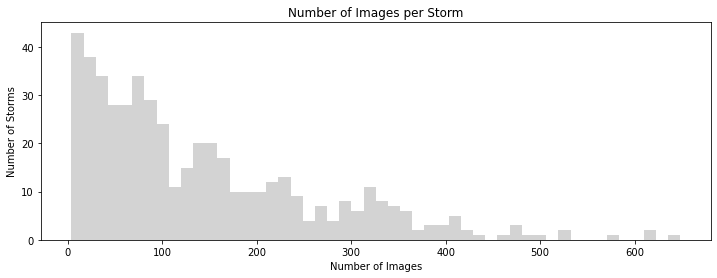

In [6]:
plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50, color="lightgray")
plt.xlabel("Number of Images")
plt.ylabel("Number of Storms")
plt.title("Number of Images per Storm")

In [7]:
train_metadata.groupby("ocean")["storm_id"].nunique()

ocean
1    264
2    230
Name: storm_id, dtype: int64

In [8]:
train_labels.head()

image_id  wind_speed
0  abs_000          43
1  abs_001          44
2  abs_002          45
3  abs_003          52
4  abs_004          53

Text(0.5, 1.0, 'Distribution of Wind Speeds')

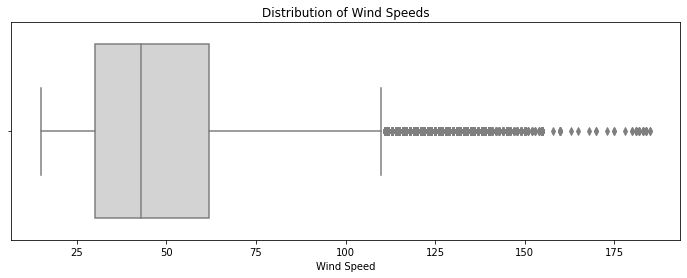

In [9]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=train_labels.wind_speed, color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

In [10]:
full_metadata = train_metadata.merge(train_labels, on="image_id")

In [11]:
def plot_wind_speeds(storm_id):
    storm = full_metadata[full_metadata.storm_id == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter("relative_time", "wind_speed", data=storm, color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")

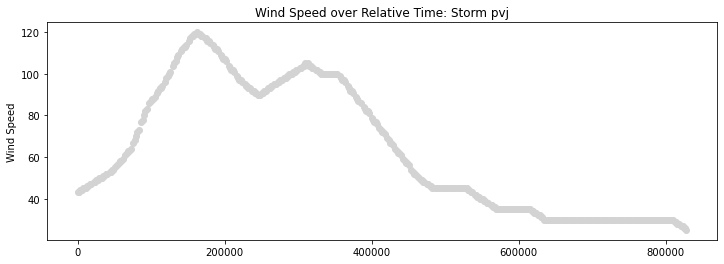

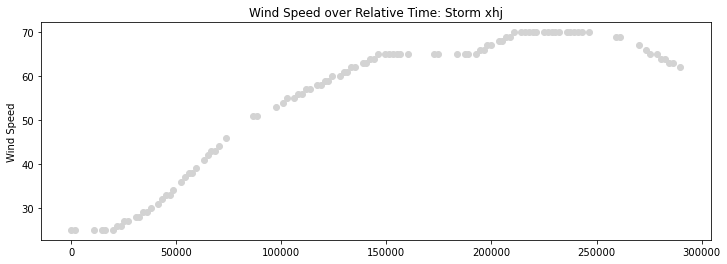

In [12]:
for storm in full_metadata.storm_id.sample(2, random_state=40):
    plot_wind_speeds(storm)

In [13]:

full_metadata["file_name"] = (
    "../input/drivendata-wind-speed-reg/train/train/"+full_metadata.image_id+".jpg"
)

In [14]:
full_metadata.head()

image_id storm_id  relative_time  ocean  wind_speed  \
0  abs_000      abs              0      2          43   
1  abs_001      abs           1800      2          44   
2  abs_002      abs           5400      2          45   
3  abs_003      abs          17999      2          52   
4  abs_004      abs          19799      2          53   

                                                    file_name  
0  ../input/drivendata-wind-speed-reg/train/train/abs_000.jpg  
1  ../input/drivendata-wind-speed-reg/train/train/abs_001.jpg  
2  ../input/drivendata-wind-speed-reg/train/train/abs_002.jpg  
3  ../input/drivendata-wind-speed-reg/train/train/abs_003.jpg  
4  ../input/drivendata-wind-speed-reg/train/train/abs_004.jpg

In [15]:
from IPython.display import Image

In [16]:
def look_at_wind_speed(wind_speed):
    sample_img = full_metadata[full_metadata.wind_speed == wind_speed].file_name.iloc[0]
    return Image(str(sample_img))

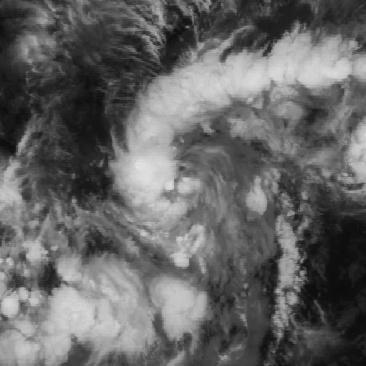

In [17]:
look_at_wind_speed(wind_speed=30)

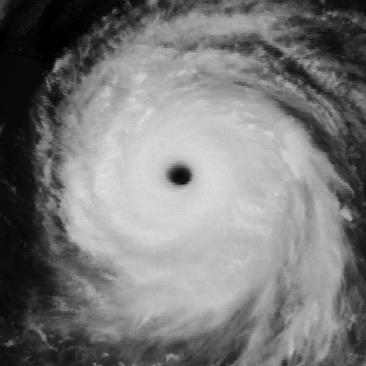

In [18]:
look_at_wind_speed(wind_speed=150)

In [19]:
from PIL import Image as pil_image
examples = [
    pil_image.open(full_metadata.iloc[i]["file_name"]).convert("RGB") for i in range(5)
]
for image in examples:
    print(image.size)

(366, 366)
(366, 366)
(366, 366)
(366, 366)
(366, 366)


In [20]:
images_per_storm = full_metadata.groupby("storm_id").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="storm_id")
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
full_metadata["pct_of_storm"] = (
    full_metadata.groupby("storm_id").cumcount() / full_metadata.images_per_storm
)
train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)

In [21]:
len(val) / len(full_metadata) * 100

19.734688358455386

In [22]:
train = train.sample(frac=0.1, replace=False, random_state=1)
val = val.sample(frac=0.1, replace=False, random_state=1)

In [23]:

# Separate features from labels
x_train = train.drop("wind_speed", axis=1)
y_train = train.wind_speed

x_val = val.drop("wind_speed", axis=1)
y_val = val.wind_speed

In [24]:
from torch.utils.data import Dataset
from torchvision import transforms
class DatasetWIND(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_train, y_train=None):
        self.data = x_train
        self.label = y_train
        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(128),
                transforms.ToTensor(),
                # All models expect the same normalization mean & std
                # https://pytorch.org/docs/stable/torchvision/models.html
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = pil_image.open(self.data.iloc[index]["file_name"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.iloc[index]["image_id"]
        if self.label is not None:
            label = self.label.iloc[index]
            sample = {"image_id": image_id, "image": image, "label": label}
        else:
            sample = {
                "image_id": image_id,
                "image": image,
            }
        return sample

In [25]:
from torch import nn
class RMSELoss(nn.Module):
    """Measures root mean square error."""

    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, true):
        return torch.sqrt(self.mse(pred, true))

In [26]:
!pip install pytorch_lightning

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [27]:
import warnings
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm

warnings.filterwarnings("ignore")
class PretrainedWindModel(pl.LightningModule):
    def __init__(self, hparams):
        super(PretrainedWindModel, self).__init__()
        self.hparams = hparams
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.num_outputs = 1  # One prediction for regression

        # Where final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "logs")
        self.log_path.mkdir(exist_ok=True)
        self.logger = pl.loggers.TensorBoardLogger(
            self.log_path, name="benchmark_model"
        )

        # Instantiate training and validation datasets
        self.train_dataset = DatasetWIND(self.x_train, self.y_train)
        self.val_dataset = DatasetWIND(self.x_val, self.y_val)
        self.model = self.prepare_model()

    def prepare_model(self):
        res_model = models.resnet152(pretrained=True)
        # Input size of 2048 for resnet152
        # https://pytorch.org/hub/pytorch_vision_resnet/
        res_model.fc = nn.Sequential(
            nn.Linear(2048, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.num_outputs),
            
        )
        return res_model

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to training mode
        loss = criterion(
            self.model.train().forward(x).squeeze(), y.type(torch.FloatTensor)
        )
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = RMSELoss()
        # Switch to evaluation mode
        loss = criterion(
            self.model.eval().forward(x).squeeze(), y.type(torch.FloatTensor)
        )
        tensorboard_logs = {"val_loss": loss}
        return {"batch_val_loss": loss, "log": tensorboard_logs}

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack(tuple(output["loss"] for output in outputs)).mean()
        return {
            "avg_epoch_train_loss": avg_train_loss,
            "progress_bar": {"avg_epoch_train_loss": avg_train_loss},
            "log": {"avg_epoch_train_loss": avg_train_loss},
        }

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(
            tuple(output["batch_val_loss"] for output in outputs)
        ).mean()
        return {
            "avg_epoch_val_loss": avg_val_loss,
            "progress_bar": {"avg_epoch_val_loss": avg_val_loss},
            "log": {"avg_epoch_val_loss": avg_val_loss},
        }

    ## Convenience Methods ##

    def fit(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=self.logger,
            checkpoint_callback=pl.callbacks.ModelCheckpoint(
                filepath=self.output_path,
                monitor="avg_epoch_val_loss",
                mode="min",
                verbose=True,
            ),
            gradient_clip_val=self.hparams.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hparams.get("val_sanity_checks", 0),
        )
        self.trainer.fit(self)

    @torch.no_grad()
    def make_submission_frame(self, x_test):
        test_dataset = DatasetWIND(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        submission_frame = pd.DataFrame(index=x_test.image_id, columns=["wind_speed"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["image"]
            preds = self.eval().forward(x)
            submission_frame.loc[batch["image_id"], "wind_speed"] = (
                preds.detach().numpy().squeeze()
            )
        submission_frame.wind_speed = submission_frame.wind_speed.astype(float)
        return submission_frame

In [28]:
hparams = {
    # Required hparams
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-5,
    "embedding_dim": 512,
    "num_layers":400,
    "dropout": 0.3,
    "max_epochs": 4,
    "batch_size": 20,
    "num_workers": 5,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

In [29]:

storm_model = PretrainedWindModel(hparams=hparams)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [30]:
storm_model.fit()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 59.2 M


Epoch 0: avg_epoch_val_loss reached 20.32206 (best 20.32206), saving model to /kaggle/working/model-outputs/epoch=0.ckpt as top 1


Epoch 1: avg_epoch_val_loss reached 10.06649 (best 10.06649), saving model to /kaggle/working/model-outputs/epoch=1.ckpt as top 1


Epoch 2: avg_epoch_val_loss reached 9.65196 (best 9.65196), saving model to /kaggle/working/model-outputs/epoch=2.ckpt as top 1


Epoch 3: avg_epoch_val_loss reached 9.19317 (best 9.19317), saving model to /kaggle/working/model-outputs/epoch=3.ckpt as top 1


In [31]:
submission_format = pd.read_csv(
    "../input/drivendata-wind-speed-reg/submission_format.csv", index_col="image_id"
)
submission_format.head()

wind_speed
image_id            
acd_123            0
acd_124            0
acd_125            0
acd_126            0
acd_127            0

In [32]:
# best_checkpoint = str(Path("./model-outputs") / "epoch=3.ckpt")
example_model = PretrainedWindModel.load_from_checkpoint("../input/best-scored-model/Model9.455.ckpt")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/best-scored-model/Model9.455.ckpt'

In [33]:
test_metadata = pd.read_csv("../input/drivendata-wind-speed-reg/test_set_features.csv")
test_metadata["file_name"] = (
      "../input/drivendata-wind-speed-reg/test/test/"+test_metadata.image_id +".jpg"
)

In [34]:
submission = example_model.make_submission_frame(test_metadata)

NameError: name 'example_model' is not defined

In [35]:
assert submission_format.index.equals(submission.index)
submission.head()

NameError: name 'submission' is not defined

In [36]:
submission = submission.round().astype(int)
submission.head()

NameError: name 'submission' is not defined

In [37]:
submission.to_csv("submission.csv", index=True)

NameError: name 'submission' is not defined